### Titanic: Machine Learning from Disaster
Starting point Predict survival on the Titanic and get familiar with ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def all_functions(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    cols = ["Age_categories","Fare_categories","Title",\
            "Cabin_type","Sex"]
    for col in cols: 
        df = create_dummies(df,col)
    return df

In [5]:
train = all_functions(train)
holdout = all_functions(holdout)

<b>Inspecting the type of the columns: SibSp and Parch (presence of parents of the person)

In [6]:
cols = ["SibSp","Parch"]

print(train[cols].dtypes)

SibSp    int64
Parch    int64
dtype: object


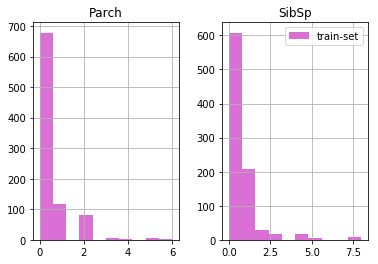

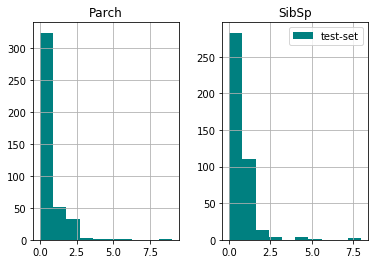

In [7]:
train[cols].hist(color="orchid",label="train-set")
plt.legend()
holdout[cols].hist(color="teal",label="test-set")
plt.legend()
plt.show()

In [8]:
#Measuring the rate of Survivals with different values in 
#"Parch" and "SibSp" columns.

Parch_values = list(train["Parch"].unique())
SibSp = list(train["SibSp"].unique())

table1 = pd.pivot_table(train,values="Survived",\
                       index=["SibSp"],\
                      aggfunc=np.mean)
table2 = pd.pivot_table(train,values="Survived",\
                        index=["Parch"],\
                       aggfunc=np.mean)
tables = pd.concat([table1,table2],axis=1)
tables

,Survived,Survived
0,0.345395,0.343658
1,0.535885,0.550847
2,0.464286,0.500000
3,0.250000,0.600000
4,0.166667,0.000000
5,0.000000,0.200000
6,NaN,0.000000
8,0.000000,NaN


##### Seems that both columns overwrite given information since the pattern is ptractically the same. We can create a third column with the sum of both.

In [9]:
train["Number_of_relatives"] = train["SibSp"] + train["Parch"]
holdout["Number_of_relatives"] = holdout["SibSp"] + holdout["Parch"]

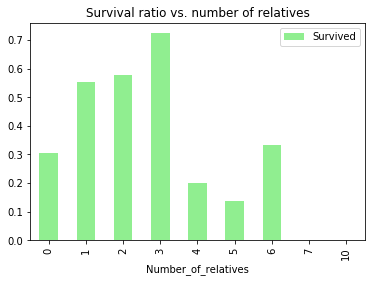

In [10]:
# Compute the survived rate for the new column
table3 = pd.pivot_table(train,values="Survived",index="Number_of_relatives"\
                       ,aggfunc=np.mean)
table3.plot(kind="bar",color="lightgreen",title="Survival ratio vs. number of relatives")
plt.legend()

##### Based on the plot we can conclude that with 1,2 or 3 relatives  the passenger had more chances to survive than with 0 relatives. We can create a new feature: "isalone" 

In [11]:
def new_feature(df):
    serie = df["Number_of_relatives"]==0
    df["isalone"] = serie.map({True:1,False:0})
    return df

train = new_feature(train)
holdout = new_feature(holdout)

In [12]:
holdout.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Age_categories', 'Fare_categories',
       'Title', 'Cabin_type', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'Number_of_relatives', 'isalone'],
      dtype='object')

In [13]:
def select_best_features(df):
    df.dropna(axis=1)
    columns = list(df.columns)
    cols_for_x = []
    candidate_column = []
    for col in columns:
        if df[col].dtype=="int64" or df[col].dtype=="float64":
            candidate_column.append(col)
    for col in candidate_column:
        if col!="PassengerId" and col!="Survived":
            cols_for_x.append(col)
   
    all_X = df[cols_for_x]
    all_y = df["Survived"]
    
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(estimator = rfc, cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = all_X.columns[selector.support_] 
    
    print(optimized_columns)
    
    return optimized_columns

In [14]:
best_features_for_train = list(select_best_features(train))

Index(['Pclass', 'Age', 'Parch', 'Fare', 'Number_of_relatives'], dtype='object')


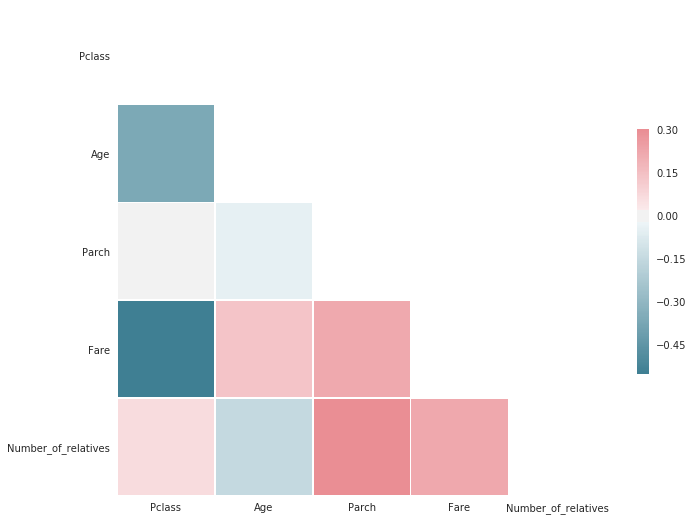

In [15]:
#Inspecting correlations within the features

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
plot_correlation_heatmap(train[best_features_for_train])

###### As we can see, the "Parch" feature correlates strongly with "Number_of_relatives" as ovious.

In [16]:
best_features_for_train.remove("Parch")
print(best_features_for_train)

['Pclass', 'Age', 'Fare', 'Number_of_relatives']


In [17]:
def select_model(df,feature_list):
    
    all_X = df[feature_list]
    all_y = df["Survived"]
    
    list_of_models = \
    [{"name":"LogisticRegression",\
      "estimator":LogisticRegression(),\
       "hyperparameters":\
        {"solver": ["newton-cg", "lbfgs", "liblinear"]}},\
     {"name":"KNeighborsClassifier",\
      "estimator":KNeighborsClassifier(),\
      "hyperparameters":\
        {"n_neighbors": range(1,20,2),"weights": ["distance", "uniform"],\
        "algorithm": ["ball_tree", "kd_tree", "brute"],\
        "p": [1,2]}},\
     {"name":"RandomForestClassifier",\
        "estimator":RandomForestClassifier(),\
        "hyperparameters":{"n_estimators":[4, 6, 9],\
        "criterion": ["entropy", "gini"],\
        "max_depth": [2, 5, 10],\
        "max_features": ["log2", "sqrt"],\
        "min_samples_leaf": [1, 5, 8],\
        "min_samples_split": [2, 3, 5]}}]
    
    for model in list_of_models:
        print(model["name"])
        
        grid = GridSearchCV(model["estimator"],\
        param_grid=model["hyperparameters"],cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_estimator"] = grid.best_estimator_
        print("best_params",model["best_params"])
        print("best_score",model["best_score"]) 
    
    return list_of_models


In [18]:
select_model_result = select_model(train,best_features_for_train)

LogisticRegression
best_params {'solver': 'newton-cg'}
best_score 0.6992143658810326
KNeighborsClassifier
best_params {'algorithm': 'brute', 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
best_score 0.6980920314253648
RandomForestClassifier
best_params {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 6}
best_score 0.734006734006734


##### We can pick the best performing model as the one with the best score:

- RandomForestClassifier:
best_params {'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 9, 'min_samples_leaf': 5}
best_score 0.734

In [19]:
def save_submission_file(trained_model,list_of_columns,\
                        file_name="submission_file.csv"):
    holdout_predictions = trained_model.predict(\
                  holdout[list_of_columns])
    
    submission_dict = {"PassengerId":holdout["PassengerId"],\
                       "Survived":holdout_predictions}

    submission = pd.DataFrame(submission_dict)
    submission.to_csv(file_name,index=False)   

In [20]:
best_trained_model = select_model_result[2]["best_estimator"]

In [21]:
save_submission_file(best_trained_model,\
                     best_features_for_train,\
                    "first_submission.csv")